In [4]:
from tensorflow.keras import models, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dense, InputLayer, BatchNormalization, Input, ReLU, Concatenate, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1,L2,l1_l2
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import save_model, load_model
import pickle
from sklearn.manifold import TSNE
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

In [5]:
seed = 909

In [3]:
#%run autoencoder-models.ipynb

## Data imports

In [6]:
image_datagen = ImageDataGenerator(rescale = 1/255)
mask_datagen = ImageDataGenerator(rescale = 1/255)

In [7]:
# we create two instances with the same arguments 
data_gen_args = dict(rescale = 1/255) 
image_datagen = ImageDataGenerator(**data_gen_args) 
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods seed = 1 
#image_datagen.fit(images, augment=True, seed=seed) 
#mask_datagen.fit(masks, augment=True, seed=seed)

train_imagegen = image_datagen.flow_from_directory('data/scan/train', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
train_maskgen = mask_datagen.flow_from_directory('data/mask/train', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_imagegen = image_datagen.flow_from_directory('data/scan/validation', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
val_maskgen = mask_datagen.flow_from_directory('data/mask/validation', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_imagegen = image_datagen.flow_from_directory('data/scan/test', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)
test_maskgen = mask_datagen.flow_from_directory('data/mask/test', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode=None,
                                  batch_size=16, seed=seed, shuffle=False)

# combine generators into one which yields image and masks 
train_generator = zip(train_imagegen, train_maskgen)
val_generator = zip(val_imagegen, val_maskgen)
test_generator = zip(test_imagegen, test_maskgen)

Found 1815 images belonging to 1 classes.
Found 1815 images belonging to 1 classes.
Found 644 images belonging to 1 classes.
Found 644 images belonging to 1 classes.
Found 605 images belonging to 1 classes.
Found 605 images belonging to 1 classes.


## Quick look

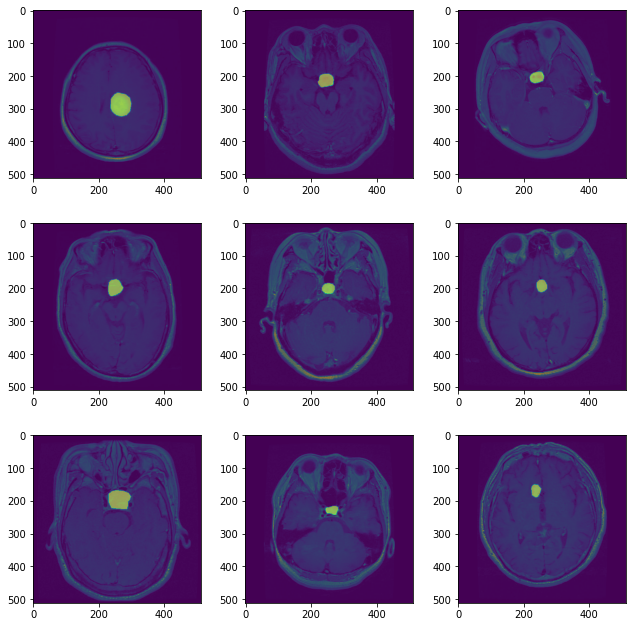

In [5]:
f,ax = plt.subplots(3,3, figsize=(9,9))
plt.tight_layout()
for i,axs in enumerate(ax.ravel()):
    axs.imshow(train_imagegen[i][1], alpha=1)
    axs.imshow(train_maskgen[i][1], alpha=0.5)

plt.show()

## Losses

In [9]:
def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    ones = K.sum(K.flatten(y_pred * y_true)) / K.sum(K.flatten(y_true))
    y_pred = K.cast(K.equal(y_pred, 0), dtype='float32')
    y_true = K.cast(K.equal(y_true, 0), dtype='float32')
    zeros = K.sum(K.flatten(y_pred * y_true)) / K.sum(K.flatten(y_true))
    return (ones + zeros)/2.0

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [11]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1+K.epsilon())) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [12]:
def focal_dice_crosse(y_true, y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true, y_pred) + dice_coef_loss(y_true, y_pred) + focal_loss()(y_true, y_pred)

## Model

In [65]:
# model-2 inspired by u-net

def convolution(inputs, filters = 32):
    conv1 = Conv2D(filters, kernel_size=(3,3), padding="same", strides=(1,1))(inputs)
    #batch_norm1 = BatchNormalization()(conv1)
    relu1 = ReLU()(conv1)
    
    conv2 = Conv2D(filters, kernel_size=(3,3), padding="same", strides=(1,1))(relu1)
    #batch_norm2 = BatchNormalization()(conv2)
    relu2 = ReLU()(conv2)
    
    return relu2
    
def encoder(inputs, filters = 32):
    cv = convolution(inputs, filters)
    maxpool = MaxPooling2D(pool_size=(4,4))(cv)
    return (cv,maxpool)

def decoder(inputs, skips , filters = 32):
    cv1 = Conv2DTranspose(filters, kernel_size=(3,3), padding="same", strides=(4,4))(inputs)
    concate = Concatenate()([cv1, skips])
    cv2 = convolution(concate, filters)
    return cv2

def U_Net(image_size):
    input1 = Input(image_size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 16)
    skip2, encoder_2 = encoder(encoder_1, 16*2)
    skip3, encoder_3 = encoder(encoder_2, 16*4)
    skip4, encoder_4 = encoder(encoder_3, 16*8)
    
    # Preparing the next block
    conv_block = convolution(encoder_4, 16*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 16*8)
    decoder_2 = decoder(decoder_1, skip3, 16*4)
    decoder_3 = decoder(decoder_2, skip2, 16*2)
    decoder_4 = decoder(decoder_3, skip1, 16)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

model = U_Net((512,512,1))
model.compile(optimizer = Adam(learning_rate=1e-3), loss=focal_dice_crosse, metrics = [mean_iou, 'accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        re_lu[0][0]                      
______________________________________________________________________________________________

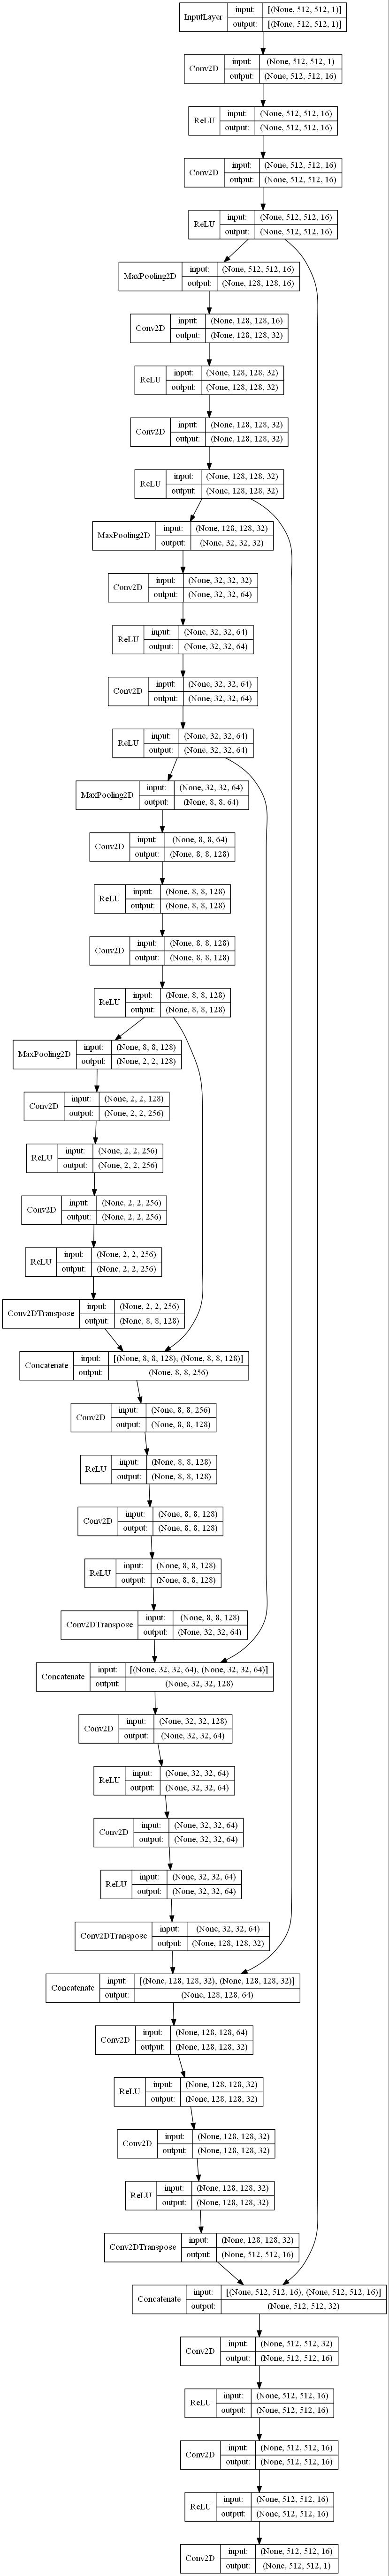

In [12]:
tf.keras.utils.plot_model(model, to_file='unet-patientWiseData.jpg', show_shapes=True, show_layer_names=False, )

## Training

In [13]:
history = model.fit(train_generator, epochs=50, steps_per_epoch = 114, 
            validation_data= val_generator, validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True, shuffle=True)
hist = history.history

Epoch 1/100
114/114 [==============================] - 88s 695ms/step - loss: 1.1080 - mean_iou: 0.4996 - accuracy: 0.9781 - val_loss: 0.9563 - val_mean_iou: 0.5667 - val_accuracy: 0.9657
Epoch 2/100
114/114 [==============================] - 80s 700ms/step - loss: 0.9524 - mean_iou: 0.5892 - accuracy: 0.9744 - val_loss: 0.9823 - val_mean_iou: 0.5268 - val_accuracy: 0.9801
Epoch 3/100
114/114 [==============================] - 81s 712ms/step - loss: 0.9618 - mean_iou: 0.5841 - accuracy: 0.9762 - val_loss: 0.9114 - val_mean_iou: 0.6251 - val_accuracy: 0.9755
Epoch 4/100
114/114 [==============================] - 82s 719ms/step - loss: 0.8710 - mean_iou: 0.6382 - accuracy: 0.9772 - val_loss: 0.8766 - val_mean_iou: 0.6557 - val_accuracy: 0.9750
Epoch 5/100
114/114 [==============================] - 82s 722ms/step - loss: 0.8630 - mean_iou: 0.6352 - accuracy: 0.9776 - val_loss: 0.8794 - val_mean_iou: 0.6187 - val_accuracy: 0.9808
Epoch 6/100
114/114 [==============================] - 82s 7

KeyboardInterrupt: 

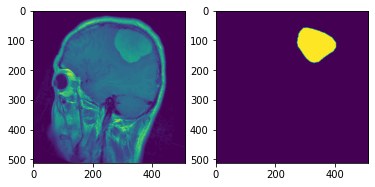

In [177]:
f,ax = plt.subplots(1,2)
for x,y in train_generator:
    ax[0].imshow(x[0].squeeze())
    ax[1].imshow(y[0].squeeze())
    
    break

NameError: name 'hist' is not defined

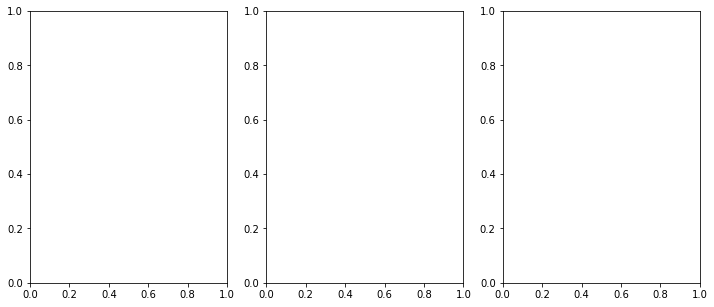

In [14]:
f,ax = plt.subplots(1,3, figsize=(12,5))
ax[0].plot(hist['loss'], label="Train Loss")
ax[0].plot(hist['val_loss'], label="Val Loss")

ax[1].plot(hist['accuracy'], label="Train Accuracy")
ax[1].plot(hist['val_accuracy'], label="Val Accuracy")

ax[2].plot(hist['mean_iou'], label="Train Mean Itersection Union")
ax[2].plot(hist['val_mean_iou'], label="Val Mean Itersection Union")


ax[0].legend()
ax[1].legend()
plt.show()

In [18]:
model = load_model('./models/model2_v1_patientWiseData.h5', custom_objects={'focal_dice_crosse':focal_dice_crosse, 'mean_iou':mean_iou})

In [192]:
save_model(model, './models/model2_v1_patientWiseData.h5')
with open("./history/model2_v1_patientWiseData_hist","wb") as f:
    pickle.dump(history.history, f)

## Visualizing Prediction on training data

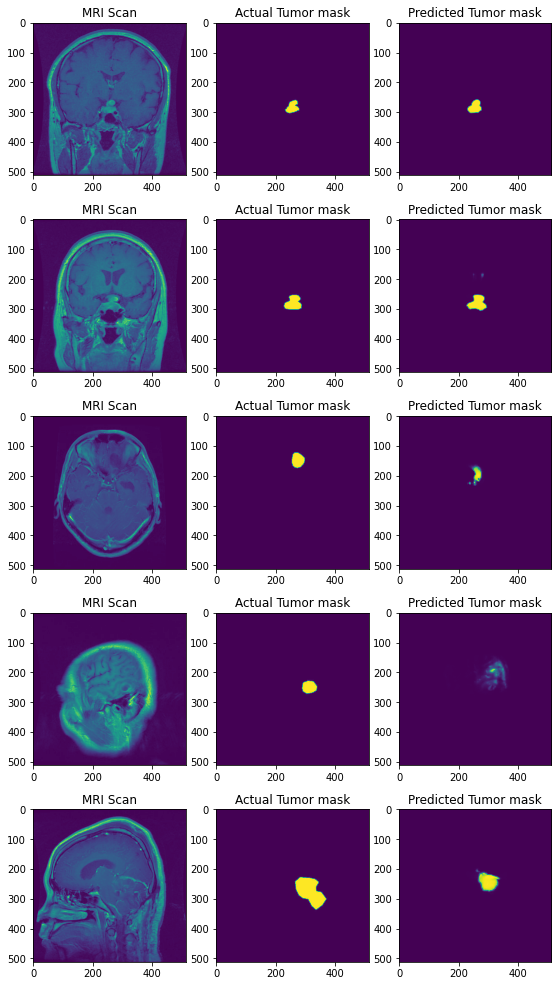

In [239]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,110)
    img = random.randint(0,15)
    
    ax[i][0].imshow(train_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(train_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(train_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()


## Visualizing Prediction on validation data

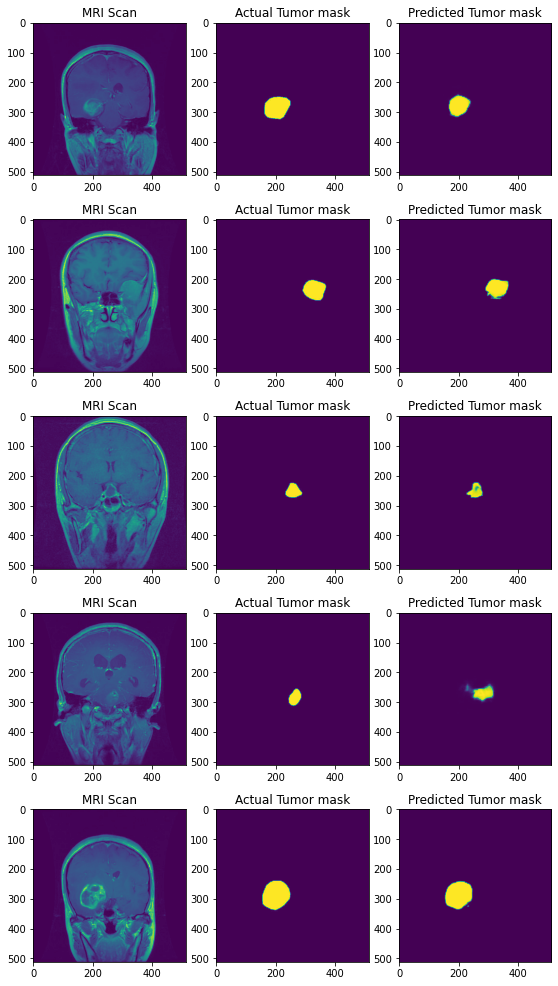

In [245]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,38)
    img = random.randint(0,15)
    
    ax[i][0].imshow(val_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(val_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(val_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()

## Visualizing Prediction on test data

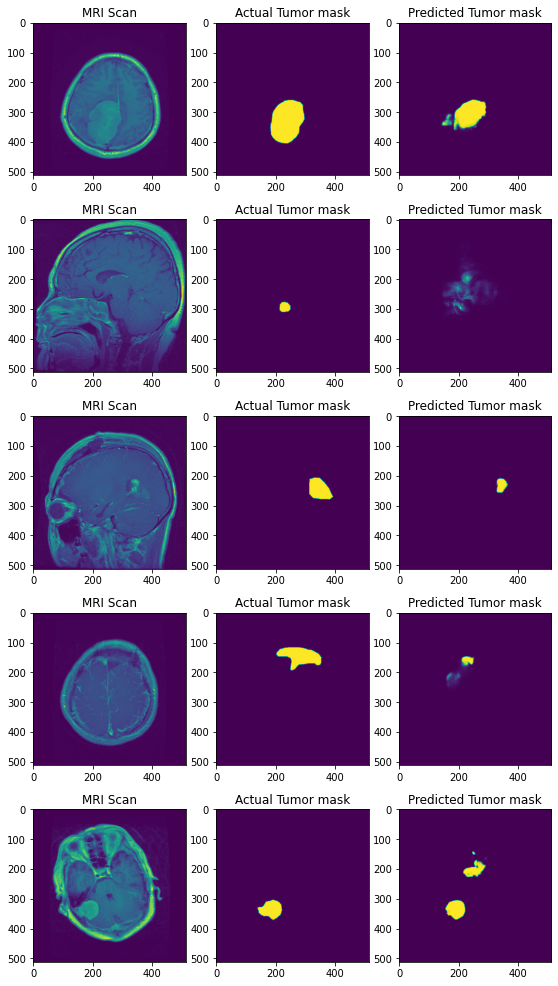

In [269]:
f,ax = plt.subplots(5,3, figsize=(12,12))


for i in range(5):
    batch = random.randint(0,37)
    img = random.randint(0,15)
    
    ax[i][0].imshow(test_imagegen[batch][img])
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(test_maskgen[batch][img])
    ax[i][1].set_title("Actual Tumor mask")
    
    ax[i][2].imshow(model.predict(test_imagegen[batch][img].reshape(1,512,512,1)).reshape(512,512))
    ax[i][2].set_title("Predicted Tumor mask")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=1.2)

plt.show()

## Inference

### TSNE

In [60]:
class_imagegen = image_datagen.flow_from_directory('for-tsne/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=1500, seed=seed, shuffle=True)

Found 3064 images belonging to 3 classes.


In [61]:
encoder_input = Input(shape=model.layers[0].input_shape[0][1:])
encoder_model = encoder_input
for layer in model.layers[1:25]:
    encoder_model = layer(encoder_model)

encoder_model = Model(inputs = encoder_input, outputs = encoder_model)

In [62]:
tsne_out = TSNE(n_components=2, learning_rate='auto', init='pca').fit_transform(K.batch_flatten(encoder_model.predict(class_imagegen[0][0])))

D:\Programs\Anaconda\envs\tf2.8\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


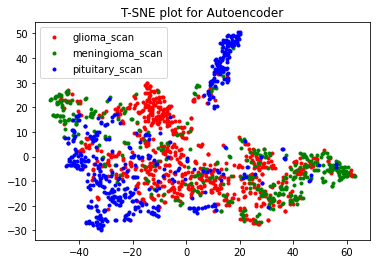

In [64]:
idx = (class_imagegen[0][1] == 1)
sc0 = plt.scatter(tsne_out[idx[:,0],0], tsne_out[idx[:,0],1],  marker='.', color='red')
sc1 = plt.scatter(tsne_out[idx[:,1],0], tsne_out[idx[:,1],1],  marker='.', color='green')
sc2 = plt.scatter(tsne_out[idx[:,2],0], tsne_out[idx[:,2],1],  marker='.', color='blue')

plt.title("T-SNE plot for Autoencoder")
plt.legend((sc0,sc1,sc2),(class_imagegen.class_indices))
plt.show()

### Saliency Maps and gradCAM

In [186]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
    

def score_function_grad(output):
    return mean_iou(output, y)

def score_function(output):
    return output

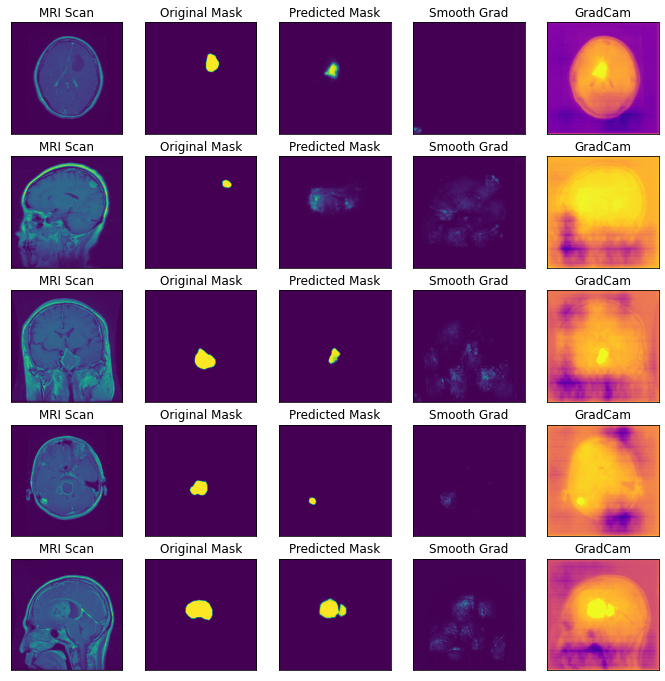

In [285]:
f,ax = plt.subplots(5,5, figsize=(15,15))

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])

for i in range(5):
    
    batch = random.randint(0,37)
    img = random.randint(0,15)
    
    X = np.expand_dims(test_imagegen[batch][image], axis=0)
    y = np.expand_dims(test_maskgen[batch][image], axis=0)

    saliency = Saliency(model, 
                        model_modifier=ReplaceToLinear(),
                        clone=True)
    saliency_map = saliency(score_function, X,
                            smooth_samples =20,
                            smooth_noise= 0.20)
    cm = normalize(saliency_map)

    gradcam = Gradcam(model,
                      model_modifier=ReplaceToLinear(),
                      clone=True)

    cam = gradcam(score_function_grad,
                  X,
                  penultimate_layer=-1)
        
    
    ax[i][0].imshow(X.squeeze())
    ax[i][0].set_title("MRI Scan")
    
    ax[i][1].imshow(y.squeeze())
    ax[i][1].set_title("Original Mask")

    ax[i][2].imshow(model.predict(X).squeeze())
    ax[i][2].set_title("Predicted Mask")    

    ax[i][3].imshow(cm.squeeze(),cmap='viridis')
    ax[i][3].set_title("Smooth Grad")

    ax[i][4].imshow(1-cam.squeeze(),cmap='plasma')
    ax[i][4].set_title("GradCam")
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.7)


plt.show()

## Classification based on latent layer

In [253]:
train_imagegen = image_datagen.flow_from_directory('classification/train/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)
val_imagegen = image_datagen.flow_from_directory('classification/validation/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)
test_imagegen = image_datagen.flow_from_directory('classification/test/', target_size=(512, 512), 
                                  color_mode='grayscale', class_mode='categorical',
                                  batch_size=16, seed=seed, shuffle=True)

Found 1839 images belonging to 3 classes.
Found 613 images belonging to 3 classes.
Found 612 images belonging to 3 classes.


In [254]:
classification_input = Input(shape=model.layers[0].input_shape[0][1:])
classification_model = classification_input
for layer in model.layers[1:25]:
    layer.trainable = False
    classification_model = layer(classification_model)

flat = Flatten()(classification_model)
dense1 = Dense(512, activation='relu')(flat)
dense2 = Dense(64, activation='relu')(dense1)
final = Dense(3, activation='softmax')(dense2)


classification_model = Model(inputs = classification_input, outputs = final)
classification_model.compile(optimizer = Adam(), loss=CategoricalCrossentropy(), metrics =['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [255]:
classification_model.summary()

Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      160       
_________________________________________________________________
re_lu (ReLU)                 (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 16)      2320      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512, 512, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      464

In [256]:
classifi_hist = classification_model.fit(train_imagegen, epochs=7, steps_per_epoch = 114, 
            validation_data= val_imagegen, validation_steps=38,validation_batch_size=16, workers=-1,
            use_multiprocessing=True)

Epoch 1/7
114/114 [==============================] - 12s 94ms/step - loss: 0.7473 - accuracy: 0.6928 - recall: 0.5326 - precision: 0.7487 - val_loss: 0.6745 - val_accuracy: 0.7204 - val_recall: 0.6842 - val_precision: 0.7235
Epoch 2/7
114/114 [==============================] - 9s 78ms/step - loss: 0.5932 - accuracy: 0.7482 - recall: 0.7115 - precision: 0.7739 - val_loss: 0.6547 - val_accuracy: 0.7122 - val_recall: 0.7056 - val_precision: 0.7333
Epoch 3/7
114/114 [==============================] - 9s 79ms/step - loss: 0.5592 - accuracy: 0.7614 - recall: 0.7263 - precision: 0.7886 - val_loss: 0.6160 - val_accuracy: 0.7352 - val_recall: 0.6974 - val_precision: 0.7640
Epoch 4/7
114/114 [==============================] - 9s 79ms/step - loss: 0.4994 - accuracy: 0.7916 - recall: 0.7592 - precision: 0.8079 - val_loss: 0.5711 - val_accuracy: 0.7566 - val_recall: 0.7401 - val_precision: 0.7812
Epoch 5/7
114/114 [==============================] - 9s 80ms/step - loss: 0.4929 - accuracy: 0.7800 - r

In [257]:
classification_model.evaluate(test_imagegen)

39/39 [==============================] - 2s 35ms/step - loss: 0.6080 - accuracy: 0.7500 - recall: 0.7157 - precision: 0.7644


[0.607988715171814, 0.75, 0.7156862616539001, 0.764397919178009]

In [258]:
save_model(classification_model, './models/model2_v1_patientWiseData_classification.h5')
with open("./history/model2_v1_patientWiseData_classification_hist","wb") as f:
    pickle.dump(classifi_hist.history, f)

In [259]:
with open("./history/model2_v2_classification_hist","rb") as f:
    t = pickle.load(f)

## Final loss, accuracy, thoughts